In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

ponifile = "../PROCESSED_DATA/LAB6_calib_scan4.poni"


## Load masks

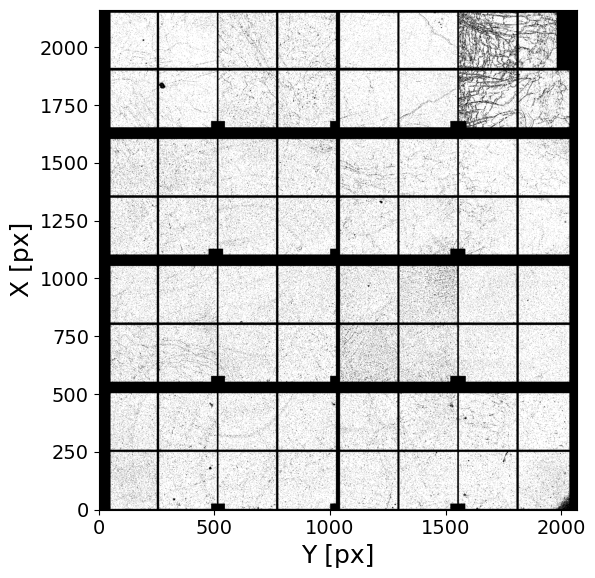

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

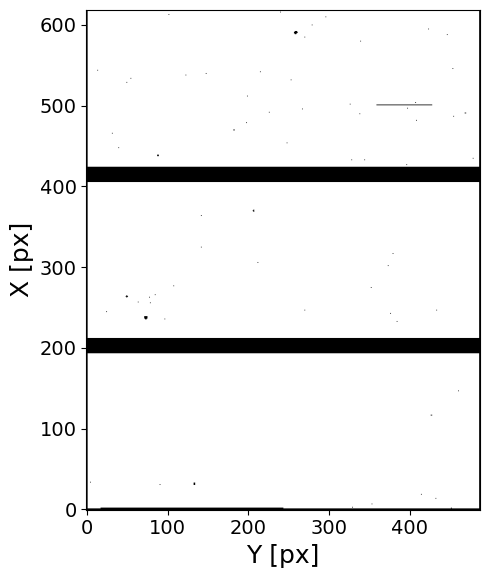

In [3]:
pilatus_mask = ~np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow(pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 3
Nfi, Nff = 0, 80_000
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
theta = 10.0
Qc = 1.91
#############################



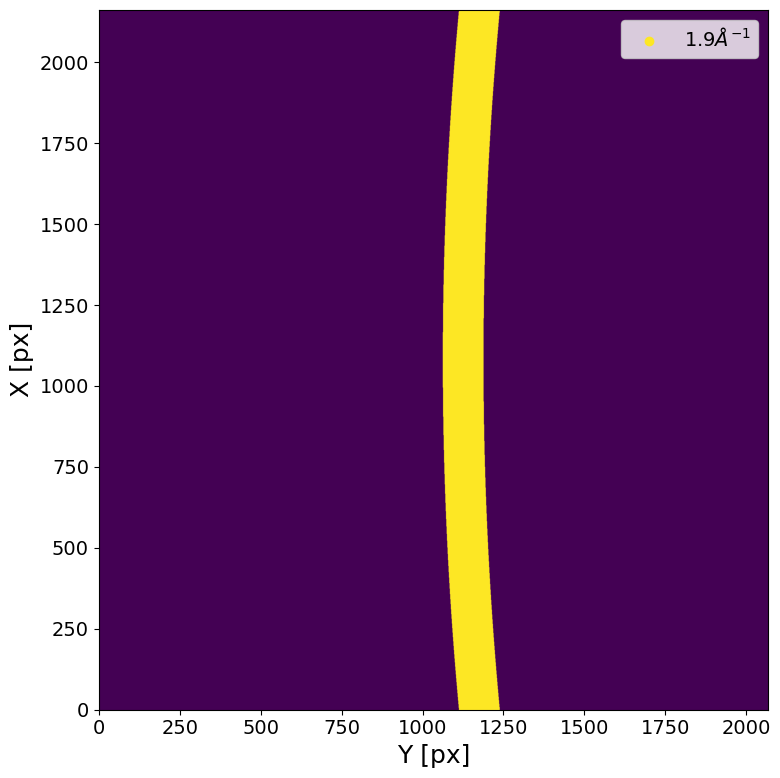

In [ ]:
###########
Q = 1.9
dq = 0.01
###########

#Qmask = XPCS.gen_Qmask(Ei, theta, Qc+np.array([-1,0,1])*2*dq, dq, Qmap_plot=False)
Qmask = XPCS.gen_Qmask(Ei, theta, 1.9, dq, Qmap_plot=False)

In [10]:
Qmask

{1.9: array([False, False, False, ..., False, False, False], shape=(4471016,))}

## XPCS scan: delcoup=10, T=12h (Ta2O5_2.5um, 2, 4)

In [22]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_0002_0004.npy')
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=None, Nff=int(1e7), load_mask=load_mask, n_jobs=50, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
T =  15.707186611111112 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00017.h5 (18/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00022.h5 (23/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00036.h5 (37/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00032.h5 (33/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00033.h5 (34/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00043.h5 (44/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00029.h5 (30/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00035.h5 (36/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00040.h5 (41/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00023.h5 (24/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/2001 loops)
	 -> loading file eiger4m_v2_sp

### Intensity analysis

In [23]:
########################
Nf_down1 = 15492456
Nf_up1 = 16790601
Nf_down2 = 21877393
Nf_up2 = 23830327
########################

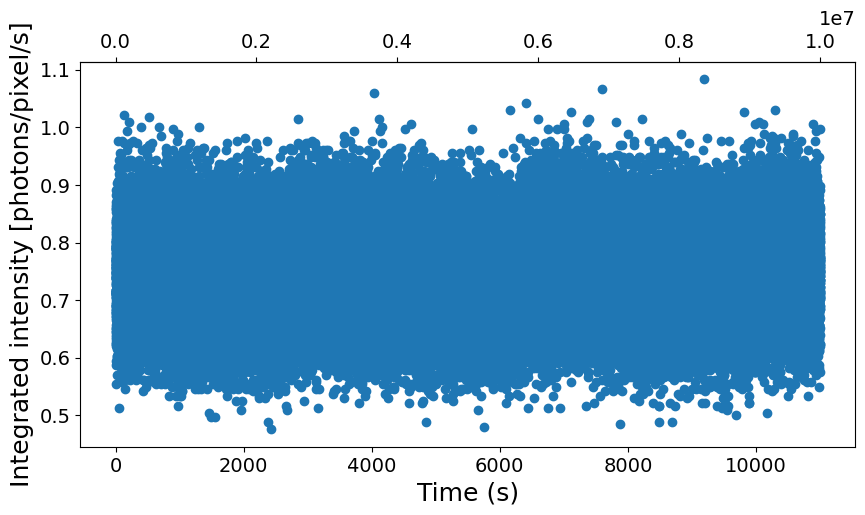

In [26]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)

plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.axvspan(t_It[Nf_down1//Nstep], t_It[Nf_up1//Nstep], color='red', alpha=0.2)
#plt.axvspan(t_It[Nf_down2//Nstep], t_It[Nf_up2//Nstep], color='blue', alpha=0.2)
plt.show()

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4249687 pixels (of 4471016 => 95.05 %)
################################################################################



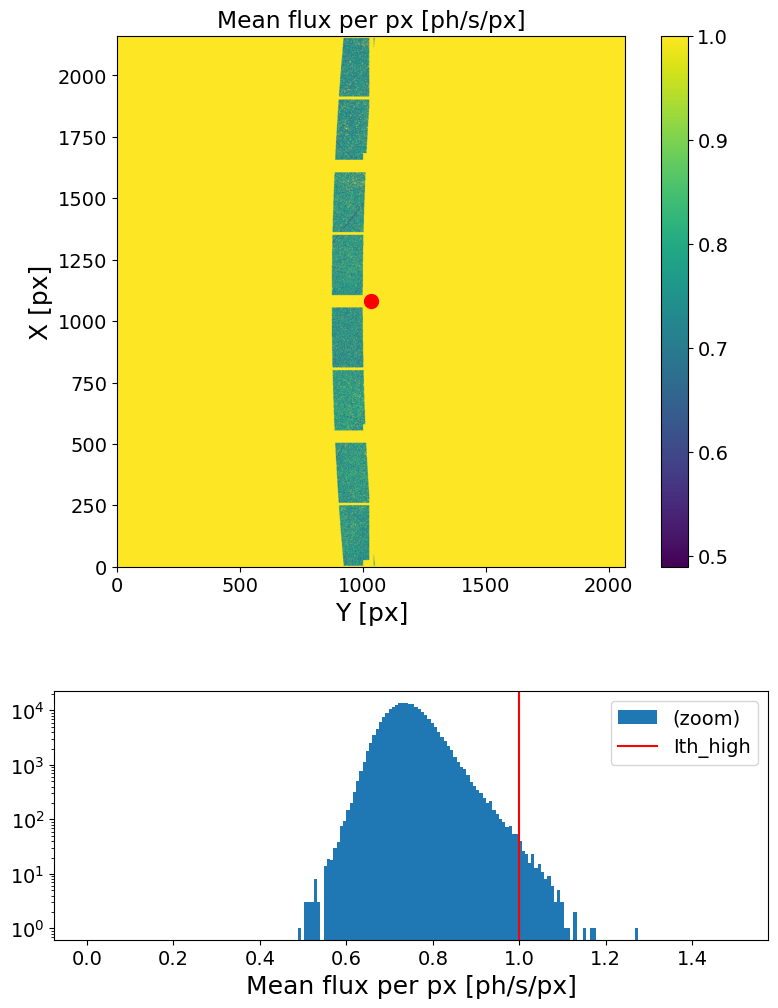

In [27]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Pilatus

In [232]:
'''
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
Nfi, Nff =  0, 100
#######################################
scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
for k in scan.keys(): print(f"{k} -> {scan[k]} ;")

pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=0, Nff=300, Nstep=1)
'''

'\n#######################################\nsample_name = \'Ta2O5_2.5um\'\nNdataset = 2\nNscan = 4\nNfi, Nff =  0, 100\n#######################################\nscan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)\nfor k in scan.keys(): print(f"{k} -> {scan[k]} ;")\n\npilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=0, Nff=300, Nstep=1)\n'

Plot image

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(pilatus_data[16], vmin=1400, vmax=4000)

Compute Sq

In [ ]:
q, Sq, dSq = XPCS.get_Sq(pilatus_data, ponifile=ponifile, mask=pilatus_mask)

In [ ]:
XPCS.plot_Sq(q, Sq, itime=2, )

### Linear correlation

In [30]:
###################
Nfi = int(0e7)
Nff = int(1e7)
Lbin = 1000
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=True)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 4.44 s)
	 | 10000 frames X 221520 pixels
	 | memory usage (np.array @ float32) = 8.252 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 4.11 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.39 s)



In [31]:
############################
t1, t2 = 0, 100
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [33]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.04 s)



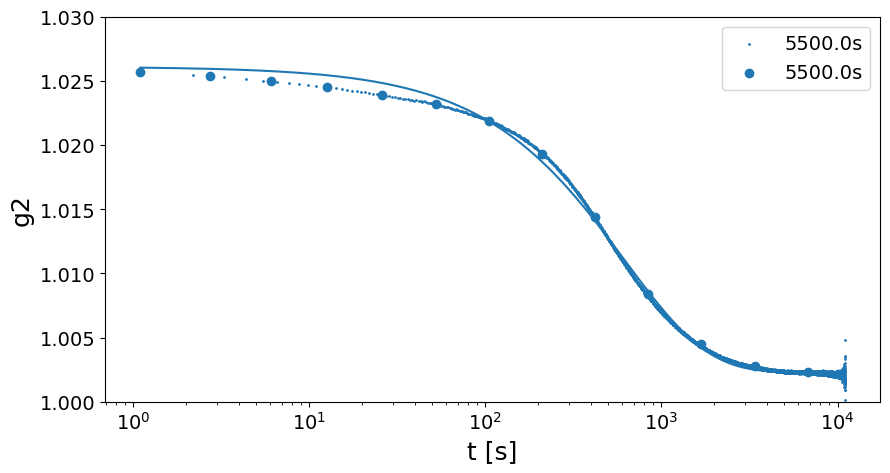

name,value,standard error,relative error,initial value,min,max,vary
tau,617.231569,1.17245451,(0.19%),1000,0.00000000,1000000.00,True
beta,0.91720150,0.00177870,(0.19%),1,0.00000000,2.00000000,True
c,0.02381176,3.0520e-05,(0.13%),0.02,0.00000000,1.00000000,True
y0,1.00229885,2.4295e-06,(0.00%),1,0.00000000,2.00000000,True


In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()

params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    fit_out.loc[k] = [fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *fit_out.loc[k].values[:4])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

### Linear by dose

In [ ]:
segments = [(None, int(.75e7)), (int(.75e7), Nf_down1), (Nf_up1, Nf_down2),(Nf_up2, 30000000), (30000000, 40000000), (int(4e7), None)]
Nbunch = [2, 2, 2, 3, 4, 4]

In [ ]:
###################
Lbin = 100
mask = None
###################
if Lbin is None: Lbin=1

t, g2, t_mt, g2_mt = {}, {}, {}, {}

i = 0

for i in range(len(segments)):
    Nfi = segments[i][0]
    Nff = segments[i][1]
    G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=True)

    ################
    Nbunch = 3
    ################

    NfXbunch = int(G2t.shape[0]/Nbunch)

    if Nfi is None: Nfi = 0
    for n in range(Nbunch):
        t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)
        t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
        t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Loading frames ...


Done! (elapsed time = 7.0 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 2.43 s)
	 | 75000 frames X 209274 pixels
	 | memory usage (np.array @ float32) = 58.47 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 204.12 s)
	 | 75000 X 75000 squared matrix
	 | memory usage (np.array @ float32) = 20.955 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 7.08 s)

Computing g2...
Done! (elapsed time = 1.33 s)

Computing g2...
Done! (elapsed time = 1.33 s)

Computing g2...
Done! (elapsed time = 1.32 s)

Loading frames ...
Done! (elapsed time = 10.27 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 12.53 s)
	 | 79924 frames X 209274 pixels
	 | memory usage (np.array @ float32) = 62.309 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 247.22 s)
	 | 79924 X 79924 squared matrix
	 | memory usage (np.array @ float32) = 23.797 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 8.35 s)



In [1]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    #plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorrelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[1000, .8, .025, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.axvspan(Nf_down1*itime, Nf_up1*itime, color='red', alpha=0.2)
    plt.axvspan(Nf_down2*itime, Nf_up2*itime, color='blue', alpha=0.2)
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.axvspan(Nf_down1*itime, Nf_up1*itime, color='red', alpha=0.2)
    plt.axvspan(Nf_down2*itime, Nf_up2*itime, color='blue', alpha=0.2)
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.axvspan(Nf_down1*itime, Nf_up1*itime, color='red', alpha=0.2)
    plt.axvspan(Nf_down2*itime, Nf_up2*itime, color='blue', alpha=0.2)
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.axvspan(Nf_down1*itime, Nf_up1*itime, color='red', alpha=0.2)
    plt.axvspan(Nf_down2*itime, Nf_up2*itime, color='blue', alpha=0.2)
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

NameError: name 'plt' is not defined

### Multi-tau Correlation

In [ ]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 42870604    =>    log2(Nf) = 25.35
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**25                 24             21.7        9316172
1    5*2**23                 22              2.0         927564
2   81*2**19                 18              1.0         403276
3  163*2**18                 17              0.0         141132
4  327*2**17                 16              0.0          10060
----------------------------------------------------


In [ ]:
##### INPUTS #####
Nfi = 0
Nff = 0 +1*2**25
sparse_depth = 13
dense_depth = 24
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

Loading frames ...
Done! (elapsed time = 44.49 s)
	 | 33554432 frames X 210139 pixels
	 | sparsity = 7.49e-04
	 | memory usage (sparse.csr_array @ float32) = 59.298 GB
Computing sparse multitau G2t...


100%|██████████| 4096/4096 [14:24<00:00,  4.74it/s]


Done! (elapsed time = 865.4 s)
Computing dense multitau G2t...


100%|██████████| 11/11 [00:02<00:00,  4.97it/s]


Done! (elapsed time = 2.21 s)


In [ ]:
############################
vmin, vmax = 1.005, 1.025
lower_mt = 8
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')


## XPCS scan: delcoup=10, T=12h (Ta2O5_2.5um, 3, 9)
Super long scan for the hull night and more

In [89]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 3
Nscan = 9
#Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_0002_0004.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, scan['fast_timer_period'].size-5001
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  2.4974870555555557 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00045.h5 (46/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/1634 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/1634 loops)
	 -> loading file eiger4m_v2_sp

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4248984 pixels (of 4471016 => 95.03 %)
################################################################################



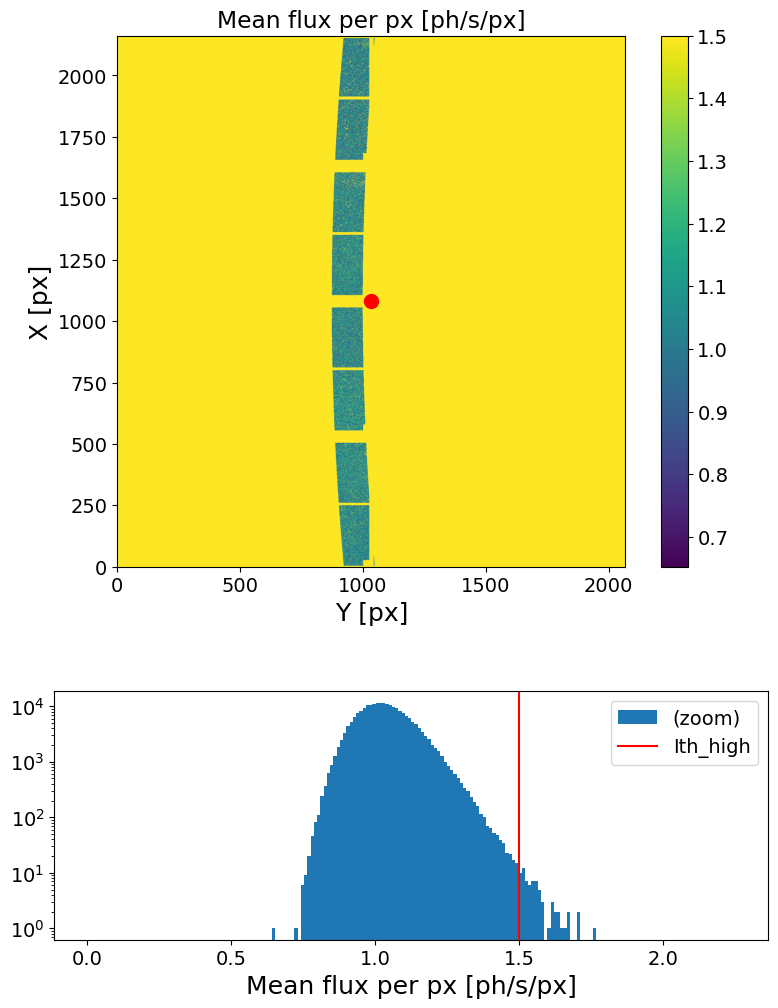

In [82]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1.5, Nfi=None, Nff=None, load_mask=load_mask, mask=None)

### Intensity analysis

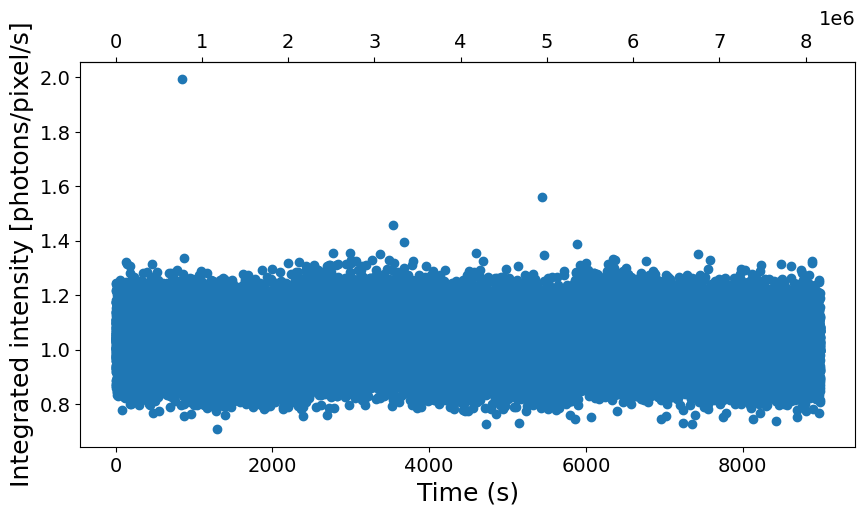

In [90]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)

plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.ylim(0)
#plt.xscale('log') 
#plt.xlim(16000, 17500)
plt.show()

### Linear correlation

In [91]:
###################
Nfi = None
Nff = None
Lbin = 1000
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=True)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 20.62 s)
	 | 8168 frames X 222100 pixels
	 | sparsity = 6.72e-01
	 | memory usage (sparse.csr_array @ float32) = 9.088 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 59.38 s)
	 | 8168 X 8168 squared matrix
	 | memory usage (np.array @ float32) = 0.249 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.23 s)



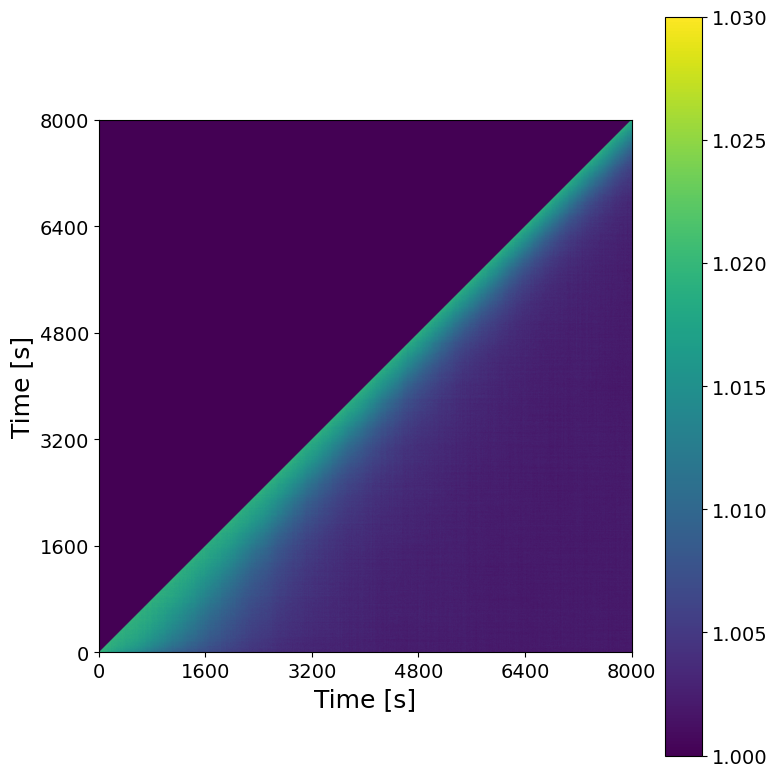

Exception ignored in: <function ResourceTracker.__del__ at 0x7b191906fce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x763cec78bce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [102]:
############################
t1, t2 = 0, 8000
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [103]:
################
Nbunch = 3
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



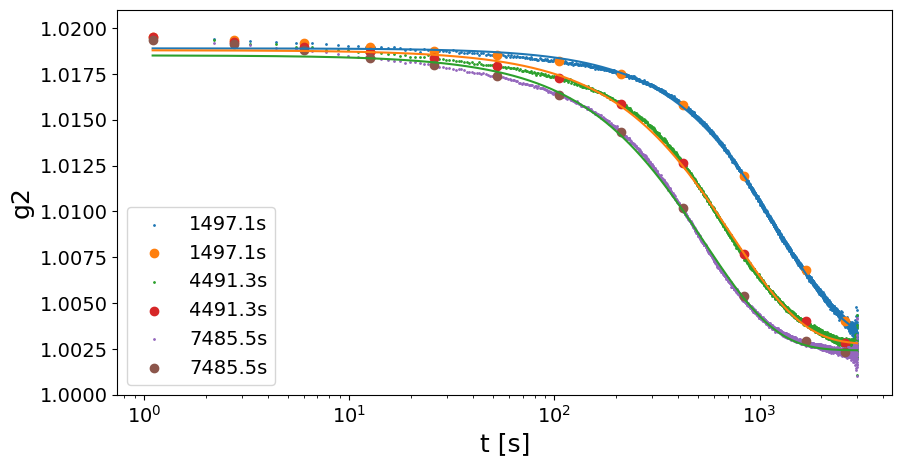

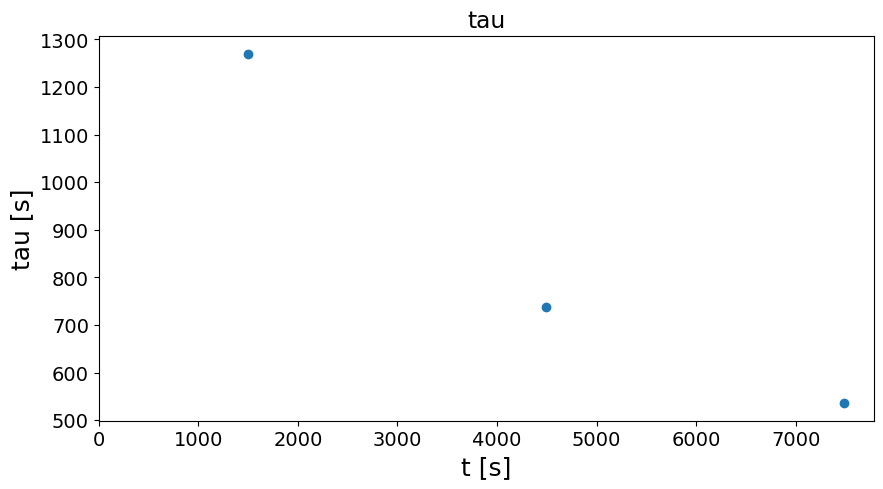

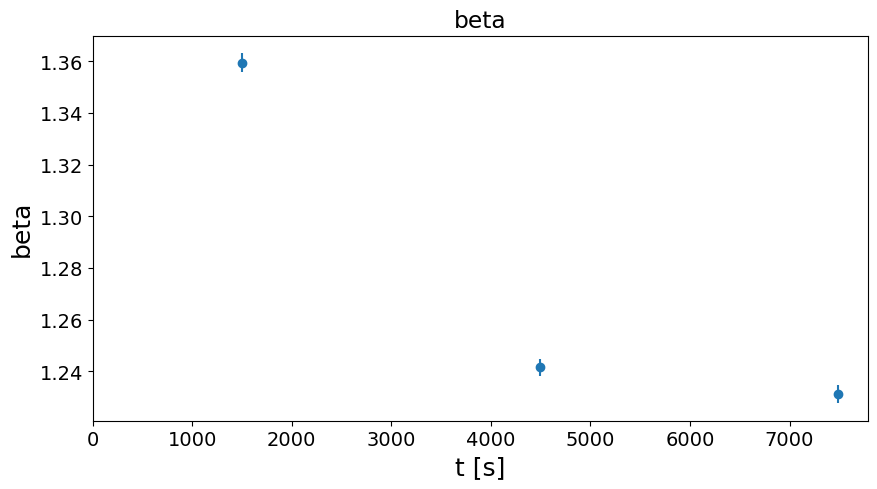

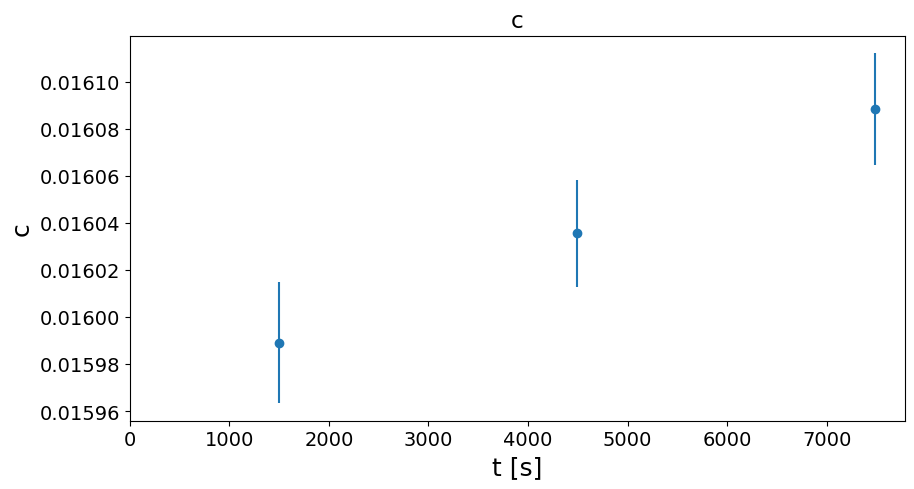

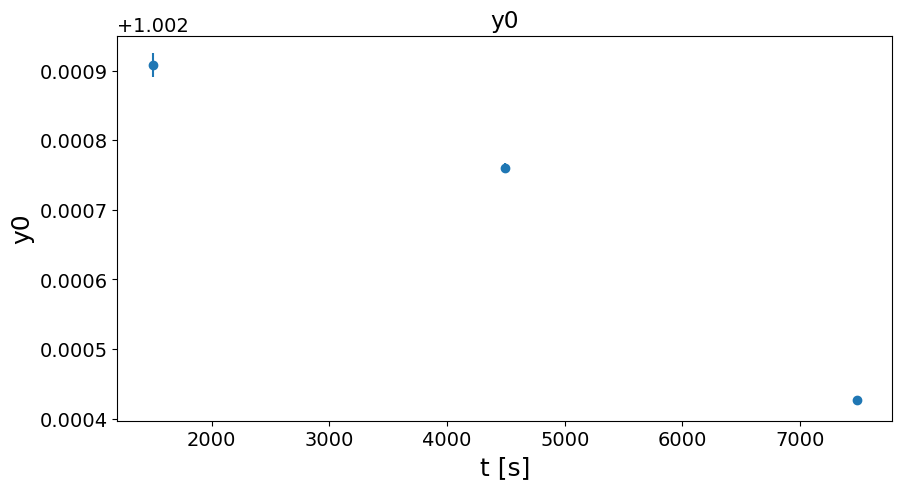

In [104]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorrelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[1000, .8, .025, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.021)
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  